In [27]:
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf
import uncertainties as unc
from uncertainties import unumpy

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

plt.rcParams['axes.formatter.use_locale'] = True

# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [43]:
data_a = pd.read_csv('dataA.csv')
data_a.x = unumpy.uarray(data_a.x, 0.2) / 100
data_a.resist = unumpy.uarray(data_a.resist, 100)
DIVIDE_A = 1 / 1000
VOLT0_A = 1.36
R0_A = 560
MIRROR_LEN = unc.ufloat(0.94, 0.01)
data_a["curr"] = VOLT0_A * DIVIDE_A / (R0_A + data_a.resist)
data_a

,x,resist,curr
0,0.2450+/-0.0020,(5.30+/-0.10)e+03,(2.32+/-0.04)e-07
1,0.2200+/-0.0020,(5.90+/-0.10)e+03,(2.105+/-0.033)e-07
2,0.1970+/-0.0020,(6.60+/-0.10)e+03,(1.899+/-0.027)e-07
3,0.1850+/-0.0020,(7.00+/-0.10)e+03,(1.799+/-0.024)e-07
4,0.1740+/-0.0020,(7.50+/-0.10)e+03,(1.687+/-0.021)e-07
5,0.1630+/-0.0020,(8.00+/-0.10)e+03,(1.589+/-0.019)e-07
6,0.1450+/-0.0020,(9.00+/-0.10)e+03,(1.423+/-0.015)e-07
7,0.1310+/-0.0020,(1.000+/-0.010)e+04,(1.288+/-0.012)e-07
8,0.1200+/-0.0020,(1.100+/-0.010)e+04,(1.176+/-0.010)e-07
9,0.1020+/-0.0020,(1.300+/-0.010)e+04,(1.003+/-0.007)e-07


In [22]:
unumpy.std_devs(data_a.curr)


array([3.96044217e-09, 3.25892130e-09, 2.65285103e-09, 2.37955264e-09,
       2.09348004e-09, 1.85605730e-09, 1.48806919e-09, 1.21958219e-09,
       1.01770812e-09, 7.39638534e-10, 4.95927560e-10, 2.67214929e-10,
       1.55643163e-10, 8.69013138e-11, 1.69555054e-11])

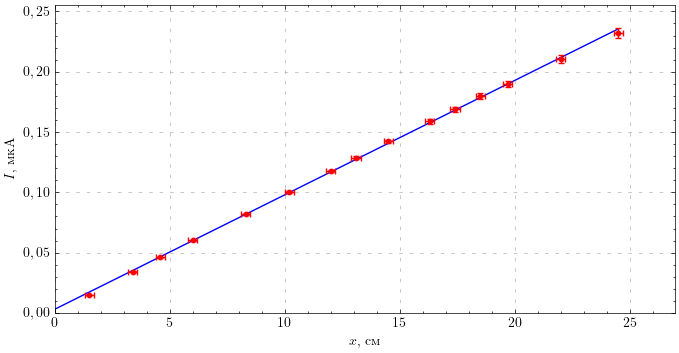

In [40]:
def plot_x_curr(ax, df, title="Зависимость тока через гальванометр от отклонения зайчика"):
  x_raw = df.x * 100
  y_raw = df.curr * 1e6
  x = unumpy.nominal_values(x_raw)
  y = unumpy.nominal_values(y_raw)
  xerr = unumpy.std_devs(x_raw)
  yerr = unumpy.std_devs(y_raw)

  p = np.poly1d(np.polyfit(x, y, 1))

  xp = np.linspace(0, x.max(), 100)

  sc, = ax.plot(xp, p(xp), c='blue')
  ax.scatter(x, y, s=10, zorder=10, c='red')
  ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor='red',
              capsize=2, c='red')
  ax.set_xlabel(r'$x$, см')
  ax.set_ylabel(r'$I$, мкА')
  # ax.set_title(title)
  ax.set_xlim(0, x.max()*1.1)
  ax.set_ylim(0, y.max()*1.1)

fig, ax = plt.subplots(figsize=(8, 4))
plot_x_curr(ax, data_a)
plt.savefig(f'{OUTPUT_DIR}/x_curr.pgf')

In [63]:
import numpy as np
from sklearn.linear_model import LinearRegression
def bootstrap(*args, n_bootstraps = 1000, fit_intercept=True):
  n = len(args[0])

  bootstraps = []
  for arg in args:
    bootstrap_samples = []
    for _ in range(n_bootstraps):
      sample = np.random.normal(loc=unumpy.nominal_values(arg), scale=unumpy.std_devs(arg), size=n)
      bootstrap_samples.append(sample)
    bootstraps.append(bootstrap_samples)

  coefficients = []
  for i in range(n_bootstraps):
    X = np.array(bootstraps[0][i]).reshape(-1, 1)
    y = np.array(bootstraps[-1][i])
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X, y)
    coefficients.append(model.coef_[0])

  coefficients = np.array(coefficients)
  mean_coefficients = np.mean(coefficients, axis=0)
  std_coefficients = np.std(coefficients, axis=0)

  return unumpy.uarray(mean_coefficients, std_coefficients)

In [73]:
coef = bootstrap(data_a.x, data_a.curr, fit_intercept=False)
dynamic_const = 2 * MIRROR_LEN * coef
print(f"Dynamic constant: {dynamic_const:.1uL}")

Dynamic constant: \left(1.82 \pm 0.02\right) \times 10^{-6}


In [151]:
def generate_latex_table(data, column_names, rounding_precisions, include_numbering=False, save_to_file=None):
  # Create the LaTeX table header
  table_header = "\\begin{tabular}{"
  if include_numbering:
    table_header += "c"
  for _ in range(len(column_names)):
    table_header += "c"
  table_header += "}\n"
  table_header += "\\toprule\n"

  # Create the column headers
  if include_numbering:
    table_header += " & "
  for i, name in enumerate(column_names):
    table_header += f"{name} & "
  table_header = table_header[:-2] + "\\\\\n"
  table_header += "\\midrule\n"

  # Create the table rows
  table_rows = ""
  for i, row in enumerate(zip(*data)):
    if include_numbering:
      table_rows += f"{i+1} & "
    for j, value in enumerate(row):
      if not unc.umath.isnan(value):
        if rounding_precisions[j] == 0:
          table_rows += rf"{value.nominal_value:.0f} & "
        else:
          table_rows += rf"${value:.{rounding_precisions[j]}uL}$ & "
      else:
        table_rows += " & "
    table_rows = table_rows[:-2] + "\\\\\n"

  # Create the table footer
  table_footer = "\\bottomrule\n"
  table_footer += "\\end{tabular}"

  # Combine the table components
  latex_table = table_header + table_rows + table_footer
  latex_table = latex_table.replace('.', ',')

  # Save to file if specified
  if save_to_file:
    with open(save_to_file, 'w') as f:
      f.write(latex_table)

  return latex_table


In [126]:
data = [data_a.x * 100, data_a.resist / 1000, data_a.curr * 1e9]
column_names = ['$x$, см', '$R$, кОм', '$I$, нА']
rounding_precisions = [1, 1, 1]

generate_latex_table(data, column_names, rounding_precisions, include_numbering=True, save_to_file=f'{OUTPUT_DIR}/tbl_x_curr.tex');

In [104]:
data_b = pd.read_csv('dataB.csv')
data_b.x = unumpy.uarray(data_b.x, 0.2) / 100
data_b.lnx = unumpy.log(data_b.x / data_b.x.shift(-1))
data_b

,x,lnx
0,0.1850+/-0.0020,0.244+/-0.018
1,0.1450+/-0.0020,0.232+/-0.022
2,0.1150+/-0.0020,0.245+/-0.028
3,0.0900+/-0.0020,0.25+/-0.04
4,0.0700+/-0.0020,0.24+/-0.05
5,0.0550+/-0.0020,0.20+/-0.06
6,0.0450+/-0.0020,0.25+/-0.07
7,0.0350+/-0.0020,0.34+/-0.10
8,0.0250+/-0.0020,0.22+/-0.13
9,0.0200+/-0.0020,NaN


In [127]:
data = [data_b.x * 100, data_b.lnx]
column_names = ['$x$, см', r'$\ln{x_n/x_{n+1}}$']
rounding_precisions = [1, 1]

generate_latex_table(data, column_names, rounding_precisions, include_numbering=True, save_to_file=f'{OUTPUT_DIR}/tbl_x_lnx.tex');

In [144]:
lnx = data_b.lnx.values
lnx = lnx[~unumpy.isnan(lnx)]
theta = lnx.mean()
print(f'Logarithmic decrement: {theta:.2uL}')

Logarithmic decrement: 0.247 \pm 0.011


In [150]:
data_c = pd.read_csv('dataC.csv')
data_c.x1 = unumpy.uarray(data_c.x1, 0.2) / 100
data_c.x2 = unumpy.uarray(data_c.x2, 0.2) / 100
data_c.resist = unumpy.uarray(data_c.resist * 1000, 100)
data_c["theta"] = unumpy.log(data_c.x1 / data_c.x2)
data_c

,x1,x2,resist,theta
0,0.0640+/-0.0020,0.0090+/-0.0020,(2.400+/-0.010)e+04,1.96+/-0.22
1,0.1000+/-0.0020,0.0200+/-0.0020,(3.200+/-0.010)e+04,1.61+/-0.10
2,0.0930+/-0.0020,0.0230+/-0.0020,(4.000+/-0.010)e+04,1.40+/-0.09
3,0.1280+/-0.0020,0.0390+/-0.0020,(4.800+/-0.010)e+04,1.19+/-0.05
4,0.1180+/-0.0020,0.0420+/-0.0020,(5.600+/-0.010)e+04,1.03+/-0.05
5,0.1080+/-0.0020,0.0430+/-0.0020,(6.400+/-0.010)e+04,0.92+/-0.05
6,0.1240+/-0.0020,0.0560+/-0.0020,(7.200+/-0.010)e+04,0.79+/-0.04


In [153]:
data = [data_c.x1 * 100, data_c.x2 * 100, data_c.resist / 1000, data_c.theta]
column_names = ['$x1$, см', '$x2$, см', '$R$, кОм', '$\\Theta$']
rounding_precisions = [1, 1, 0, 1]

generate_latex_table(data, column_names, rounding_precisions, include_numbering=True, save_to_file=f'{OUTPUT_DIR}/tbl_x1_x2.tex');

In [154]:
data_c["new_y"] = 1 / data_c.theta ** 2
data_c["new_x"] = (data_c.resist + R0_A) ** 2
data_c

,x1,x2,resist,theta,new_y,new_x
0,0.0640+/-0.0020,0.0090+/-0.0020,(2.400+/-0.010)e+04,1.96+/-0.22,0.26+/-0.06,(6.03+/-0.05)e+08
1,0.1000+/-0.0020,0.0200+/-0.0020,(3.200+/-0.010)e+04,1.61+/-0.10,0.39+/-0.05,(1.060+/-0.007)e+09
2,0.0930+/-0.0020,0.0230+/-0.0020,(4.000+/-0.010)e+04,1.40+/-0.09,0.51+/-0.07,(1.645+/-0.008)e+09
3,0.1280+/-0.0020,0.0390+/-0.0020,(4.800+/-0.010)e+04,1.19+/-0.05,0.71+/-0.06,(2.358+/-0.010)e+09
4,0.1180+/-0.0020,0.0420+/-0.0020,(5.600+/-0.010)e+04,1.03+/-0.05,0.94+/-0.09,(3.199+/-0.011)e+09
5,0.1080+/-0.0020,0.0430+/-0.0020,(6.400+/-0.010)e+04,0.92+/-0.05,1.18+/-0.13,(4.168+/-0.013)e+09
6,0.1240+/-0.0020,0.0560+/-0.0020,(7.200+/-0.010)e+04,0.79+/-0.04,1.58+/-0.16,(5.265+/-0.015)e+09


TypeError: polyfit() got an unexpected keyword argument 'fit_intercept'

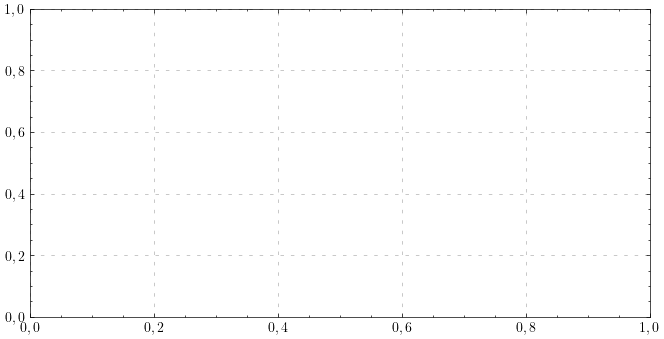

In [163]:
def plot_x_new_y_new(ax, df, title="Зависимость тока через гальванометр от отклонения зайчика"):
  x_raw = df.new_x
  y_raw = df.new_y
  x = unumpy.nominal_values(x_raw)
  y = unumpy.nominal_values(y_raw)
  xerr = unumpy.std_devs(x_raw)
  yerr = unumpy.std_devs(y_raw)

  p = np.poly1d(np.polyfit(x, y, 1))

  xp = np.linspace(0, x.max(), 100)

  sc, = ax.plot(xp, p(xp), c='blue')
  ax.scatter(x, y, s=10, zorder=10, c='red')
  ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor='red',
              capsize=2, c='red')
  ax.set_ylabel(r'$1/\Theta^2$')
  ax.set_xlabel(r'$(R+R_0)^2$, $\text{Ом}^2$')
  # ax.set_title(title)
  # ax.set_xlim(0, x.max()*1.1)
  # ax.set_ylim(0, y.max()*1.1)

fig, ax = plt.subplots(figsize=(8, 4))
plot_x_new_y_new(ax, data_c)



In [160]:
bootstrap(data_c.new_x, data_c.new_y, fit_intercept=True)

array(2.777006089694137e-10+/-2.81911101673357e-11, dtype=object)